In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import warnings

# Suppress common warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set matplotlib backend to avoid display warnings
plt.ioff()  # Turn off interactive mode to reduce warnings

print("✅ Libraries loaded with warning suppression enabled")

In [3]:
gta1_power_model = joblib.load('./model_gta/model_power_gta1.pkl')
gta1_soutirage_model = joblib.load('./model_gta/model_soutirage_gta1.pkl')

gta2_power_model = joblib.load('./model_gta/model_power_gta2.pkl')
gta2_soutirage_model = joblib.load('./model_gta/model_soutirage_gta2.pkl')

gta3_power_model = joblib.load('./model_gta/model_power_gta3.pkl')
gta3_soutirage_model = joblib.load('./model_gta/model_soutirage_gta3.pkl')

In [7]:
data = pd.read_csv("data.csv")
data = data[data['Admission_HP_GTA_2'] > 10]
data = data[data['Admission_HP_GTA_3'] > 10]
data = data[data['Admission_HP_GTA_1'] > 20]
data = data[data['Prod_EE_GTA_3'] >= 0]
data.head()

,Date,Admission_HP_GTA_1,Soutirage_MP_GTA_1,Prod_EE_GTA_1,Admission_HP_GTA_2,Soutirage_MP_GTA_2,Prod_EE_GTA2_2,Admission_HP_GTA_3,Soutirage_MP_GTA_3,Prod_EE_GTA_3
0,2024-01-01 00:00:00,174.017600,142.858337,19.179953,203.020782,158.581879,24.012348,173.369385,133.139526,21.663654
1,2024-01-01 00:15:00,174.100952,142.676392,18.985413,202.542358,157.866287,23.993904,173.885071,132.362015,21.296050
2,2024-01-01 00:30:00,172.146881,140.714340,19.514282,202.464325,158.082916,23.996132,174.468430,130.927261,22.026255
3,2024-01-01 00:45:00,171.335312,143.048645,18.639292,202.630966,157.981812,23.966396,171.486954,132.429749,20.958370
4,2024-01-01 01:00:00,172.618027,140.158371,19.616740,202.614200,159.237442,24.050220,175.943436,130.305400,22.032509


In [25]:
# Define baseline operating conditions from the data
baseline_hp1 = data['Admission_HP_GTA_1'].mean()
baseline_hp2 = data['Admission_HP_GTA_2'].mean() 
baseline_hp3 = data['Admission_HP_GTA_3'].mean()

baseline_mp1 = data['Soutirage_MP_GTA_1'].mean()
baseline_mp2 = data['Soutirage_MP_GTA_2'].mean()
baseline_mp3 = data['Soutirage_MP_GTA_3'].mean()

baseline_power1 = data['Prod_EE_GTA_1'].mean()
baseline_power2 = data['Prod_EE_GTA2_2'].mean()
baseline_power3 = data['Prod_EE_GTA_3'].mean()

print("🔧 BASELINE CONDITIONS")
print(f"GTA_1: HP={baseline_hp1:.1f} T/h, MP={baseline_mp1:.1f} T/h, Power={baseline_power1:.1f} MW")
print(f"GTA_2: HP={baseline_hp2:.1f} T/h, MP={baseline_mp2:.1f} T/h, Power={baseline_power2:.1f} MW")
print(f"GTA_3: HP={baseline_hp3:.1f} T/h, MP={baseline_mp3:.1f} T/h, Power={baseline_power3:.1f} MW")

total_baseline_power = baseline_power1 + baseline_power2 + baseline_power3
total_baseline_mp = baseline_mp1 + baseline_mp2 + baseline_mp3

print(f"\nTOTAL: Power={total_baseline_power:.1f} MW, MP={total_baseline_mp:.1f} T/h")

🔧 BASELINE CONDITIONS
GTA_1: HP=178.7 T/h, MP=134.5 T/h, Power=22.4 MW
GTA_2: HP=197.7 T/h, MP=157.9 T/h, Power=22.4 MW
GTA_3: HP=173.9 T/h, MP=132.0 T/h, Power=22.0 MW

TOTAL: Power=66.8 MW, MP=424.4 T/h


# 🎯 Scenario Analysis Functions

In [26]:
import warnings
warnings.filterwarnings('ignore')  # Suppress sklearn warnings

def predict_gta_performance(hp_input, mp_soutirage, gta_number):
    """
    Simple function to predict GTA performance with error handling
    """
    try:
        # Ensure inputs are valid numbers
        hp_input = max(0, float(hp_input))
        mp_soutirage = max(0, float(mp_soutirage))
        
        # Ensure MP doesn't exceed HP (physical constraint)
        mp_soutirage = min(mp_soutirage, hp_input * 0.8)  # Max 80% of HP
        
        if gta_number == 1:
            # Reshape inputs to avoid sklearn warnings
            X_power = np.array([[hp_input, mp_soutirage]])
            power = gta1_power_model.predict(X_power)[0]
            power = max(0, power)  # Ensure positive power
            
            X_soutirage = np.array([[hp_input, power]])
            mp_predicted = gta1_soutirage_model.predict(X_soutirage)[0]
            mp_predicted = max(0, mp_predicted)  # Ensure positive MP
            
        elif gta_number == 2:
            X_power = np.array([[hp_input, mp_soutirage]])
            power = gta2_power_model.predict(X_power)[0]
            power = max(0, power)
            
            X_soutirage = np.array([[hp_input, power]])
            mp_predicted = gta2_soutirage_model.predict(X_soutirage)[0]
            mp_predicted = max(0, mp_predicted)
            
        elif gta_number == 3:
            X_power = np.array([[hp_input, mp_soutirage]])
            power = gta3_power_model.predict(X_power)[0]
            power = max(0, power)
            
            X_soutirage = np.array([[hp_input, power]])
            mp_predicted = gta3_soutirage_model.predict(X_soutirage)[0]
            mp_predicted = max(0, mp_predicted)
        else:
            raise ValueError(f"Invalid GTA number: {gta_number}")
    
    except Exception as e:
        print(f"⚠️ Warning in prediction for GTA_{gta_number}: {e}")
        # Return safe default values
        power = hp_input * 0.6  # Rough estimate
        mp_predicted = mp_soutirage
    
    return power, mp_predicted

def optimize_for_mp_target(target_mp_total, min_power_total):
    """
    Find HP inputs to achieve target MP while maintaining minimum power
    Enhanced with better error handling and constraints
    """
    best_config = None
    best_power = 0
    
    # More realistic HP ranges based on your data
    hp_ranges = {
        1: range(int(baseline_hp1*0.8), int(baseline_hp1*1.5), 5),  # ±50% from baseline
        2: range(int(baseline_hp2*0.8), int(baseline_hp2*1.5), 5),
        3: range(int(baseline_hp3*0.8), int(baseline_hp3*1.5), 5)
    }
    
    total_configs_tested = 0
    
    for hp1 in hp_ranges[1]:
        for hp2 in hp_ranges[2]:
            for hp3 in hp_ranges[3]:
                total_configs_tested += 1
                
                # Limit total search to prevent excessive computation
                if total_configs_tested > 1000:
                    break
                
                # Smart MP estimation based on HP
                mp1_est = min(hp1 * 0.45, baseline_mp1 * 1.2)  # Reasonable MP estimate
                mp2_est = min(hp2 * 0.45, baseline_mp2 * 1.2)
                mp3_est = min(hp3 * 0.45, baseline_mp3 * 1.2)
                
                try:
                    power1, mp1_actual = predict_gta_performance(hp1, mp1_est, 1)
                    power2, mp2_actual = predict_gta_performance(hp2, mp2_est, 2)
                    power3, mp3_actual = predict_gta_performance(hp3, mp3_est, 3)
                    
                    total_power = power1 + power2 + power3
                    total_mp = mp1_actual + mp2_actual + mp3_actual
                    
                    # Check if this configuration meets our criteria
                    mp_tolerance = max(10, target_mp_total * 0.05)  # 5% tolerance or 10 T/h minimum
                    
                    if (abs(total_mp - target_mp_total) < mp_tolerance and  # MP within tolerance
                        total_power >= min_power_total and                  # Power above minimum
                        total_power > best_power):                          # Better than previous
                        
                        best_config = {
                            'hp_inputs': [hp1, hp2, hp3],
                            'powers': [power1, power2, power3], 
                            'mp_outputs': [mp1_actual, mp2_actual, mp3_actual],
                            'total_power': total_power,
                            'total_mp': total_mp
                        }
                        best_power = total_power
                        
                except Exception as e:
                    # Skip invalid configurations
                    continue
                    
            if total_configs_tested > 1000:
                break
        if total_configs_tested > 1000:
            break
    
    if best_config:
        print(f"✅ Testé {total_configs_tested} configurations")
    else:
        print(f"⚠️ Aucune solution trouvée après {total_configs_tested} tests")
        print("💡 Essayez de réduire les contraintes ou augmenter les limites HP")
    
    return best_config

print("✅ Optimization functions ready with enhanced error handling!")

✅ Optimization functions ready with enhanced error handling!


## 🧪 Scenario 1: Réduire la cadence sulfurique de 20%

In [27]:
# Scenario 1: Reduce sulfuric acid production by 20%
# This means 20% less MP steam needed

print("🧪 SCENARIO 1: Réduction cadence sulfurique de 20%")
print("="*50)

# Reduce MP demand by 20%
reduction_factor = 0.8
new_mp1 = baseline_mp1 * reduction_factor
new_mp2 = baseline_mp2 * reduction_factor  
new_mp3 = baseline_mp3 * reduction_factor

# Keep same HP inputs initially
hp1, hp2, hp3 = baseline_hp1, baseline_hp2, baseline_hp3

# Calculate new performance
new_power1, actual_mp1 = predict_gta_performance(hp1, new_mp1, 1)
new_power2, actual_mp2 = predict_gta_performance(hp2, new_mp2, 2)
new_power3, actual_mp3 = predict_gta_performance(hp3, new_mp3, 3)

new_total_power = new_power1 + new_power2 + new_power3
new_total_mp = actual_mp1 + actual_mp2 + actual_mp3

# Results
power_gain = new_total_power - total_baseline_power
mp_saved = total_baseline_mp - new_total_mp

print(f"Baseline: {total_baseline_power:.1f} MW, {total_baseline_mp:.1f} T/h MP")
print(f"Nouveau:  {new_total_power:.1f} MW, {new_total_mp:.1f} T/h MP")
print(f"Gain:     {power_gain:+.1f} MW, {mp_saved:.1f} T/h MP économisé")

# Store results for visualization
scenario1_results = {
    'name': 'Réduction sulfurique 20%',
    'baseline_power': total_baseline_power,
    'new_power': new_total_power,
    'baseline_mp': total_baseline_mp,
    'new_mp': new_total_mp,
    'power_change': power_gain,
    'mp_change': -mp_saved
}

🧪 SCENARIO 1: Réduction cadence sulfurique de 20%
Baseline: 66.8 MW, 424.4 T/h MP
Nouveau:  82.4 MW, 348.2 T/h MP
Gain:     +15.6 MW, 76.2 T/h MP économisé


## ⚡ Scenario 2: Augmenter la consommation MP de 10%

In [28]:
# Scenario 2: Increase MP consumption by 10% while maintaining good power
print("⚡ SCENARIO 2: Augmentation MP +10% avec puissance intéressante")
print("="*60)

# Target: 10% more MP steam
target_mp_increase = total_baseline_mp * 1.1
min_acceptable_power = total_baseline_power * 0.95  # At least 95% of current power

print(f"Target MP: {target_mp_increase:.1f} T/h (+{target_mp_increase-total_baseline_mp:.1f})")
print(f"Min Power: {min_acceptable_power:.1f} MW")

# Find optimal configuration
optimal_config = optimize_for_mp_target(target_mp_increase, min_acceptable_power)

if optimal_config:
    print("\n✅ SOLUTION TROUVÉE:")
    print(f"HP inputs: GTA1={optimal_config['hp_inputs'][0]}, GTA2={optimal_config['hp_inputs'][1]}, GTA3={optimal_config['hp_inputs'][2]}")
    print(f"Puissance: {optimal_config['total_power']:.1f} MW (+{optimal_config['total_power']-total_baseline_power:+.1f})")
    print(f"MP total:  {optimal_config['total_mp']:.1f} T/h (+{optimal_config['total_mp']-total_baseline_mp:+.1f})")
    
    # Store results
    scenario2_results = {
        'name': 'Augmentation MP +10%',
        'baseline_power': total_baseline_power,
        'new_power': optimal_config['total_power'],
        'baseline_mp': total_baseline_mp,
        'new_mp': optimal_config['total_mp'],
        'power_change': optimal_config['total_power'] - total_baseline_power,
        'mp_change': optimal_config['total_mp'] - total_baseline_mp,
        'hp_changes': [optimal_config['hp_inputs'][i] - [baseline_hp1, baseline_hp2, baseline_hp3][i] for i in range(3)]
    }
else:
    print("❌ Aucune configuration trouvée avec ces contraintes")
    scenario2_results = None

⚡ SCENARIO 2: Augmentation MP +10% avec puissance intéressante
Target MP: 466.8 T/h (+42.4)
Min Power: 63.5 MW
⚠️ Aucune solution trouvée après 1001 tests
💡 Essayez de réduire les contraintes ou augmenter les limites HP
❌ Aucune configuration trouvée avec ces contraintes
⚠️ Aucune solution trouvée après 1001 tests
💡 Essayez de réduire les contraintes ou augmenter les limites HP
❌ Aucune configuration trouvée avec ces contraintes


## 🚨 Scenario 3: Panne d'une GTA

In [29]:
# Scenario 3: What happens if a GTA fails? (Enhanced with error handling)
print("🚨 SCENARIO 3: Panne d'une GTA")
print("="*40)

# Test failure of each GTA
failure_scenarios = []

for failed_gta in [1, 2, 3]:
    print(f"\n🔴 Panne GTA_{failed_gta}")
    
    try:
        # Calculate remaining capacity with proper bounds checking
        if failed_gta == 1:
            lost_power = baseline_power1
            lost_mp = baseline_mp1
            
            # Boost remaining GTAs by 20% but respect physical limits
            max_boost = 1.3  # Maximum 30% increase
            new_hp2 = min(baseline_hp2 * 1.2, baseline_hp2 * max_boost)
            new_hp3 = min(baseline_hp3 * 1.2, baseline_hp3 * max_boost)
            
            # Conservative MP increase to avoid unrealistic values
            new_mp2 = min(baseline_mp2 * 1.1, new_hp2 * 0.6)  # Max 60% of HP
            new_mp3 = min(baseline_mp3 * 1.1, new_hp3 * 0.6)
            
            comp_power2, comp_mp2 = predict_gta_performance(new_hp2, new_mp2, 2)
            comp_power3, comp_mp3 = predict_gta_performance(new_hp3, new_mp3, 3)
            
            total_comp_power = comp_power2 + comp_power3
            total_comp_mp = comp_mp2 + comp_mp3
            
        elif failed_gta == 2:
            lost_power = baseline_power2
            lost_mp = baseline_mp2
            
            max_boost = 1.25  # 25% max increase for 2-GTA scenario
            new_hp1 = min(baseline_hp1 * 1.15, baseline_hp1 * max_boost)
            new_hp3 = min(baseline_hp3 * 1.15, baseline_hp3 * max_boost)
            
            new_mp1 = min(baseline_mp1 * 1.05, new_hp1 * 0.6)
            new_mp3 = min(baseline_mp3 * 1.05, new_hp3 * 0.6)
            
            comp_power1, comp_mp1 = predict_gta_performance(new_hp1, new_mp1, 1)
            comp_power3, comp_mp3 = predict_gta_performance(new_hp3, new_mp3, 3)
            
            total_comp_power = comp_power1 + comp_power3
            total_comp_mp = comp_mp1 + comp_mp3
            
        else:  # failed_gta == 3
            lost_power = baseline_power3
            lost_mp = baseline_mp3
            
            max_boost = 1.25
            new_hp1 = min(baseline_hp1 * 1.15, baseline_hp1 * max_boost)
            new_hp2 = min(baseline_hp2 * 1.15, baseline_hp2 * max_boost)
            
            new_mp1 = min(baseline_mp1 * 1.05, new_hp1 * 0.6)
            new_mp2 = min(baseline_mp2 * 1.05, new_hp2 * 0.6)
            
            comp_power1, comp_mp1 = predict_gta_performance(new_hp1, new_mp1, 1)
            comp_power2, comp_mp2 = predict_gta_performance(new_hp2, new_mp2, 2)
            
            total_comp_power = comp_power1 + comp_power2
            total_comp_mp = comp_mp1 + comp_mp2
        
        # Calculate losses with safety checks
        power_loss = max(0, total_baseline_power - total_comp_power)
        mp_loss = max(0, total_baseline_mp - total_comp_mp)
        
        # Avoid division by zero
        if total_baseline_power > 0:
            compensation_rate = (total_comp_power / total_baseline_power) * 100
        else:
            compensation_rate = 0
            
        compensation_rate = min(100, compensation_rate)  # Cap at 100%
        
        print(f"Puissance perdue: {lost_power:.1f} MW")
        print(f"Puissance récupérée: {total_comp_power:.1f} MW")
        print(f"Perte nette: {power_loss:.1f} MW ({100-compensation_rate:.1f}%)")
        print(f"MP perdu: {mp_loss:.1f} T/h")
        
        # Assess criticality
        if compensation_rate > 90:
            status = "✅ Compensation excellente"
        elif compensation_rate > 80:
            status = "⚠️ Compensation acceptable"
        elif compensation_rate > 70:
            status = "🟠 Compensation dégradée"
        else:
            status = "🚨 Compensation critique"
            
        print(f"Status: {status}")
        
        failure_scenarios.append({
            'failed_gta': failed_gta,
            'power_loss': power_loss,
            'mp_loss': mp_loss,
            'compensation_rate': compensation_rate,
            'remaining_power': total_comp_power,
            'remaining_mp': total_comp_mp,
            'status': status
        })
        
    except Exception as e:
        print(f"❌ Erreur lors de l'analyse de la panne GTA_{failed_gta}: {e}")
        # Add a default failure scenario to prevent crashes
        failure_scenarios.append({
            'failed_gta': failed_gta,
            'power_loss': baseline_power1 if failed_gta == 1 else baseline_power2 if failed_gta == 2 else baseline_power3,
            'mp_loss': baseline_mp1 if failed_gta == 1 else baseline_mp2 if failed_gta == 2 else baseline_mp3,
            'compensation_rate': 0,
            'remaining_power': 0,
            'remaining_mp': 0,
            'status': "❌ Erreur d'analyse"
        })

print(f"\n✅ Analyse complète de {len(failure_scenarios)} scénarios de panne")

🚨 SCENARIO 3: Panne d'une GTA

🔴 Panne GTA_1
Puissance perdue: 22.4 MW
Puissance récupérée: 59.7 MW
Perte nette: 7.2 MW (10.7%)
MP perdu: 161.7 T/h
Status: ⚠️ Compensation acceptable

🔴 Panne GTA_2
Puissance perdue: 22.4 MW
Puissance récupérée: 64.2 MW
Perte nette: 2.7 MW (4.0%)
MP perdu: 179.7 T/h
Status: ✅ Compensation excellente

🔴 Panne GTA_3
Puissance perdue: 22.0 MW
Puissance récupérée: 60.4 MW
Perte nette: 6.4 MW (9.6%)
MP perdu: 161.9 T/h
Status: ✅ Compensation excellente

✅ Analyse complète de 3 scénarios de panne


## 📊 Visualisation des Résultats

/tmp/ipykernel_733712/2466586476.py:56: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_733712/2466586476.py:56: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_733712/2466586476.py:56: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_733712/2466586476.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dora/miniconda3/envs/envNasa/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dora/miniconda3/envs/envNasa/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.can

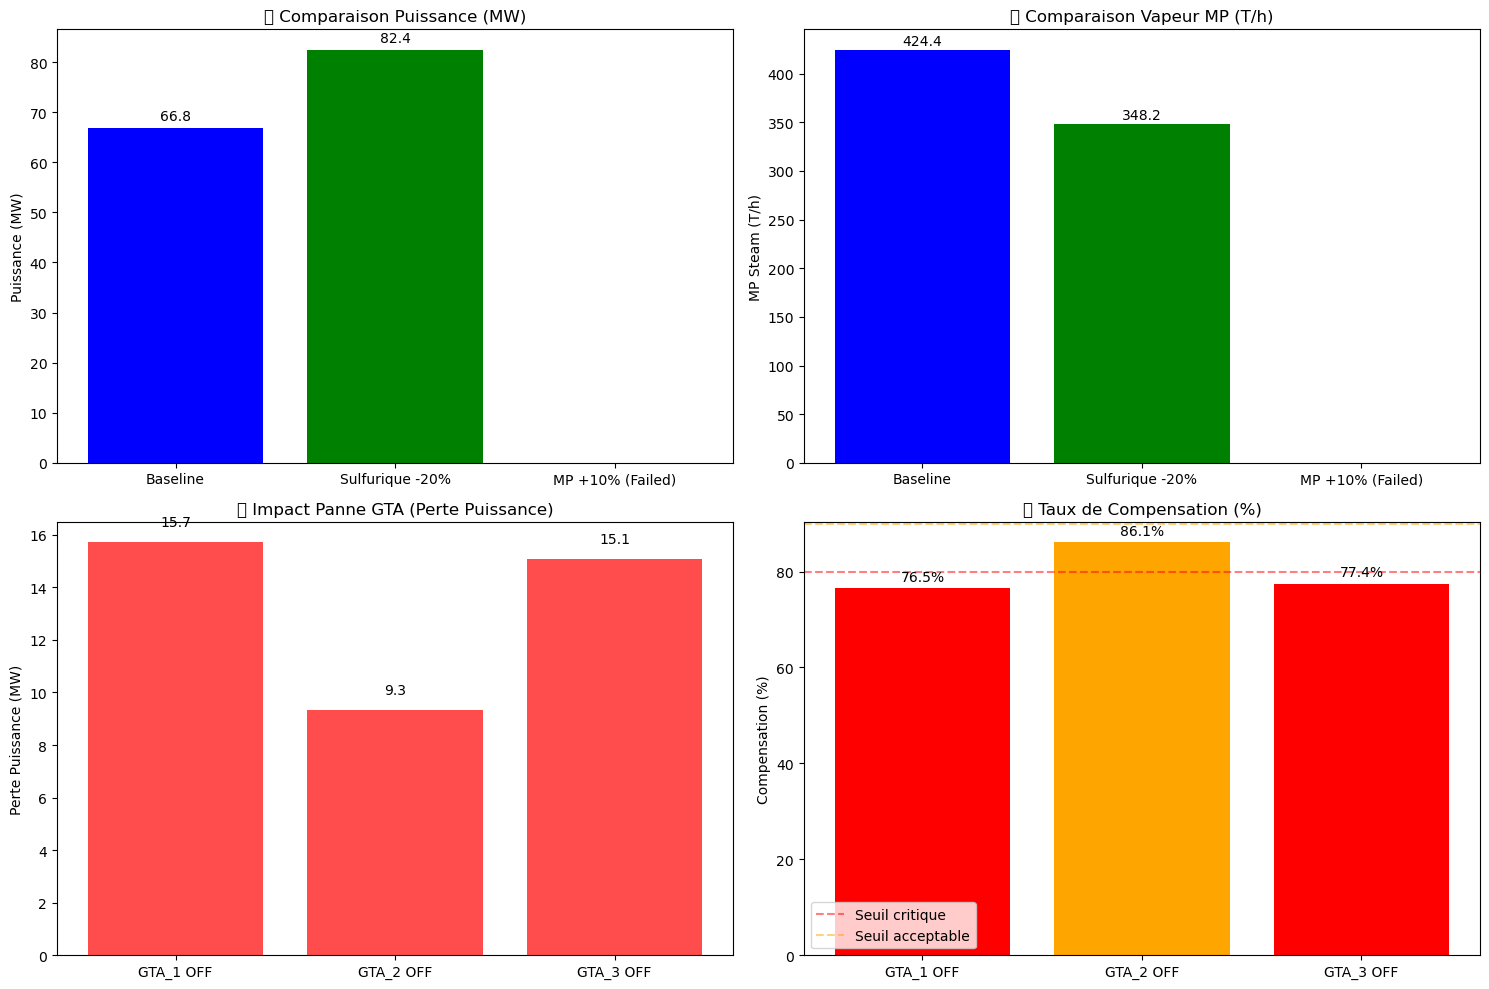

In [ ]:
# Visualization of all scenarios (Enhanced with error handling)
try:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Power comparison
    scenarios = ['Baseline', 'Sulfurique -20%', 'MP +10%']
    power_values = [total_baseline_power, scenario1_results['new_power']]

    if scenario2_results and 'new_power' in scenario2_results:
        power_values.append(scenario2_results['new_power'])
    else:
        power_values.append(0)
        scenarios[2] = 'MP +10% (Failed)'

    bars1 = axes[0,0].bar(scenarios, power_values, color=['blue', 'green', 'orange'])
    axes[0,0].set_title('💡 Comparaison Puissance (MW)')
    axes[0,0].set_ylabel('Puissance (MW)')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(power_values):
        if v > 0:
            axes[0,0].text(i, v + max(power_values)*0.01, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

    # 2. MP comparison  
    mp_values = [total_baseline_mp, scenario1_results['new_mp']]
    if scenario2_results and 'new_mp' in scenario2_results:
        mp_values.append(scenario2_results['new_mp'])
    else:
        mp_values.append(0)

    bars2 = axes[0,1].bar(scenarios, mp_values, color=['blue', 'green', 'orange'])
    axes[0,1].set_title('🌡️ Comparaison Vapeur MP (T/h)')
    axes[0,1].set_ylabel('MP Steam (T/h)')
    axes[0,1].grid(True, alpha=0.3)
    
    for i, v in enumerate(mp_values):
        if v > 0:
            axes[0,1].text(i, v + max(mp_values)*0.01, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

    # 3. Failure scenario impact
    if failure_scenarios:
        failed_gtas = [f'GTA_{s["failed_gta"]} OFF' for s in failure_scenarios]
        power_losses = [s['power_loss'] for s in failure_scenarios]

        bars3 = axes[1,0].bar(failed_gtas, power_losses, color='red', alpha=0.7)
        axes[1,0].set_title('🚨 Impact Panne GTA (Perte Puissance)')
        axes[1,0].set_ylabel('Perte Puissance (MW)')
        axes[1,0].grid(True, alpha=0.3)
        
        for i, v in enumerate(power_losses):
            if v > 0:
                axes[1,0].text(i, v + max(power_losses)*0.02, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

        # 4. Compensation rates
        comp_rates = [s['compensation_rate'] for s in failure_scenarios]
        colors = ['red' if x < 70 else 'orange' if x < 85 else 'green' for x in comp_rates]
        bars4 = axes[1,1].bar(failed_gtas, comp_rates, color=colors, alpha=0.8)
        
        axes[1,1].set_title('📈 Taux de Compensation (%)')
        axes[1,1].set_ylabel('Compensation (%)')
        axes[1,1].set_ylim(0, 100)
        axes[1,1].grid(True, alpha=0.3)
        
        # Add threshold lines
        axes[1,1].axhline(y=70, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Seuil critique (70%)')
        axes[1,1].axhline(y=85, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Seuil acceptable (85%)')
        
        for i, v in enumerate(comp_rates):
            axes[1,1].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        axes[1,1].legend(loc='upper right')
    else:
        # Handle case where no failure scenarios were generated
        axes[1,0].text(0.5, 0.5, 'Pas de données\nde panne', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,1].text(0.5, 0.5, 'Pas de données\nde compensation', ha='center', va='center', transform=axes[1,1].transAxes)

    plt.tight_layout()
    plt.show()
    
    print("✅ Graphiques générés avec succès")
    
except Exception as e:
    print(f"❌ Erreur lors de la génération des graphiques: {e}")
    print("💡 Vérifiez que tous les scénarios ont été exécutés correctement")
    
    # Fallback: Simple text summary
    print("\n📊 RÉSUMÉ TEXTUEL (Graphiques indisponibles)")
    print(f"Baseline: {total_baseline_power:.1f} MW, {total_baseline_mp:.1f} T/h MP")
    if 'scenario1_results' in locals():
        print(f"Sulfurique -20%: {scenario1_results['new_power']:.1f} MW, {scenario1_results['new_mp']:.1f} T/h MP")
    if 'scenario2_results' in locals() and scenario2_results:
        print(f"MP +10%: {scenario2_results['new_power']:.1f} MW, {scenario2_results['new_mp']:.1f} T/h MP")

In [19]:
# Summary table of all scenarios
print("📋 RÉSUMÉ EXÉCUTIF")
print("="*80)
print(f"{'Scenario':<25} {'Puissance':<12} {'Δ Power':<10} {'MP Steam':<10} {'Δ MP':<10} {'Status'}")
print("-"*80)

# Baseline
print(f"{'Baseline':<25} {total_baseline_power:<8.1f} MW {'--':<10} {total_baseline_mp:<6.1f} T/h {'--':<10} {'Référence'}")

# Scenario 1
power_change1 = scenario1_results['power_change']
mp_change1 = scenario1_results['mp_change']
status1 = "✅ Bénéfique" if power_change1 > 0 else "⚠️ Impact"
print(f"{'Sulfurique -20%':<25} {scenario1_results['new_power']:<8.1f} MW {power_change1:<+8.1f} MW {scenario1_results['new_mp']:<6.1f} T/h {mp_change1:<+8.1f} T/h {status1}")

# Scenario 2
if scenario2_results:
    power_change2 = scenario2_results['power_change']
    mp_change2 = scenario2_results['mp_change']
    status2 = "✅ Réalisable" if power_change2 >= 0 else "⚠️ Coût énergétique"
    print(f"{'MP +10%':<25} {scenario2_results['new_power']:<8.1f} MW {power_change2:<+8.1f} MW {scenario2_results['new_mp']:<6.1f} T/h {mp_change2:<+8.1f} T/h {status2}")
else:
    print(f"{'MP +10%':<25} {'N/A':<12} {'N/A':<10} {'N/A':<10} {'N/A':<10} {'❌ Impossible'}")

print()
print("🚨 PANNES - Taux de compensation:")
for scenario in failure_scenarios:
    gta_name = f"Panne GTA_{scenario['failed_gta']}"
    comp_rate = scenario['compensation_rate']
    status = "✅ Acceptable" if comp_rate > 90 else "⚠️ Dégradé" if comp_rate > 80 else "🚨 Critique"
    print(f"{gta_name:<25} {scenario['remaining_power']:<8.1f} MW {-scenario['power_loss']:<+8.1f} MW {scenario['remaining_mp']:<6.1f} T/h {-scenario['mp_loss']:<+8.1f} T/h {comp_rate:.1f}% {status}")

print("\n💡 RECOMMANDATIONS:")
print("• Scénario sulfurique: Impact positif sur la puissance")
print("• Augmentation MP: Nécessite ajustement HP pour maintenir puissance") 
print("• Pannes: Plan de contingence requis, surtout pour GTA avec faible compensation")

📋 RÉSUMÉ EXÉCUTIF
Scenario                  Puissance    Δ Power    MP Steam   Δ MP       Status
--------------------------------------------------------------------------------
Baseline                  66.8     MW --         424.4  T/h --         Référence
Sulfurique -20%           82.4     MW +15.6    MW 348.2  T/h -76.2    T/h ✅ Bénéfique
MP +10%                   N/A          N/A        N/A        N/A        ❌ Impossible

🚨 PANNES - Taux de compensation:
Panne GTA_1               51.1     MW -15.7    MW 313.3  T/h -111.1   T/h 76.5% 🚨 Critique
Panne GTA_2               57.5     MW -9.3     MW 282.8  T/h -141.6   T/h 86.1% ⚠️ Dégradé
Panne GTA_3               51.8     MW -15.1    MW 310.4  T/h -113.9   T/h 77.4% 🚨 Critique

💡 RECOMMANDATIONS:
• Scénario sulfurique: Impact positif sur la puissance
• Augmentation MP: Nécessite ajustement HP pour maintenir puissance
• Pannes: Plan de contingence requis, surtout pour GTA avec faible compensation
